In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
path = './Data/Time_series_analysis_and_forecast_DATASET.csv'
df = pd.read_csv(path)
df.head(4)

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910


In [3]:
df["FullDate"] = pd.to_datetime(df["FullDate"])

In [4]:
df = df.set_index("FullDate")

In [5]:
def DB_Info(df):
    """
    Returns detailed information about the dataset such as it's data types, 
    basics statistics, number of missing values in each columns & duplicated rows
    """
    print(df.info())
    print('-'*20)
    print(df.describe(include='all'))
    print('-'*20)
    d = df.isnull().sum()
    # prints the columns with null values with a total count of null values it contains
    if d[d>0].any():
      print(d[d>0])
    else:
      print('There are no null values')
    print('-'*20)
    # prints the duplicated rows
    if df.duplicated().any():
      print(df[df.duplicated()])
    else:
      print('There are no duplicated rows')
    print('-'*20)
    for col in df.columns:
      a = df[col].unique()
      if len(a)<15:
        print(f'{col} has {len(a)} unique values ->> {a}', end = '\n\n')
    
DB_Info(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       92016 non-null  float64
 1   SysLoad    92016 non-null  float64
 2   GasPrice   92016 non-null  float64
 3   ElecPrice  92016 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB
None
--------------------
               Tmax       SysLoad      GasPrice     ElecPrice
count  92016.000000  92016.000000  92016.000000  92016.000000
mean     231.696688    797.623357      6.016163     65.798356
std     4562.128748    613.520156      2.608116    213.144084
min        9.900000  -1596.810100      0.000000   -924.820000
25%       17.300000    417.119800      3.936900     31.543750
50%       21.900000    856.467925      5.165600     48.715000
75%       27.600000   1221.293675      8.023300     76.495000
max    99999.900000   3264.166300     29.990000  14700.

In [6]:
daily_df = df.resample('D').sum()
daily_df.reset_index(inplace = True)

Text(0, 0.5, 'Electric Price')

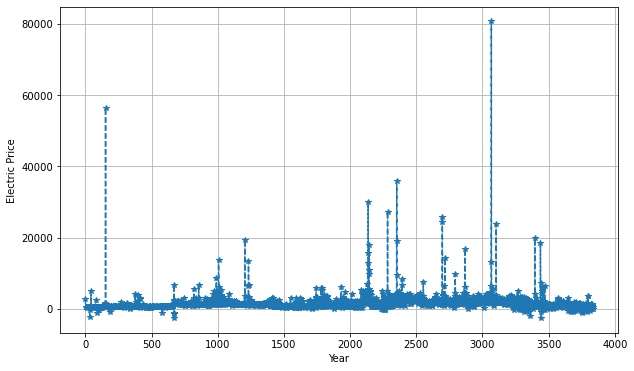

In [7]:
plt.figure(figsize=( 10 , 6 ))
plt.plot(daily_df.index, daily_df['ElecPrice'], '--' , marker= '*')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Electric Price')

In [8]:
SysLoad_ADF = adfuller(daily_df['SysLoad'])
GasPrice_ADF = adfuller(daily_df['GasPrice'])
print(f'p-value of SysLoad is {round(SysLoad_ADF[1], 6)} & GasPrice is {round(GasPrice_ADF[1], 6)}.')

p-value of SysLoad is 0.004254 & GasPrice is 0.045027.


In [9]:
ElecPrice_ADF = adfuller(daily_df['ElecPrice'])
GasPrice_Crit = round(GasPrice_ADF[4]['10%'], 4)
ElecPrice_Crit = round(ElecPrice_ADF[4]['5%'], 4)
print(f'10% Critical Value of GasPrice is {GasPrice_Crit} & 5% Critical Value of ElecPrice is {ElecPrice_Crit}.')

10% Critical Value of GasPrice is -2.5672 & 5% Critical Value of ElecPrice is -2.8623.


In [10]:
daily_uni_df = daily_df.drop(columns=['Tmax', 'SysLoad', 'GasPrice'])
daily_uni_df = daily_uni_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})

In [11]:
daily_uni_train_df = daily_uni_df[:2757]
daily_uni_test_df = daily_uni_df[2757:]

In [12]:
daily_uni_train_df.shape, daily_uni_test_df.shape

((2757, 2), (1077, 2))

In [13]:
uni_model = Prophet()
uni_model.fit(daily_uni_train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
uni_forecast = uni_model.predict(daily_uni_test_df)

In [15]:
def MAPE(y_true, y_pred, round_x): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return round(MAPE, round_x)

In [16]:
uni_MAPE = MAPE(daily_uni_test_df['y'], uni_forecast['yhat'], 2)
print(f' MAPE of the univariate time series is {uni_MAPE}%.')

 MAPE of the univariate time series is 543.44%.


In [17]:
# rmse

uni_RMSE = round(np.sqrt(mean_squared_error(daily_uni_test_df['y'], uni_forecast['yhat'])), 2)
print(f'RMSE of the univariate time series is {uni_RMSE}.')

RMSE of the univariate time series is 3205.53.


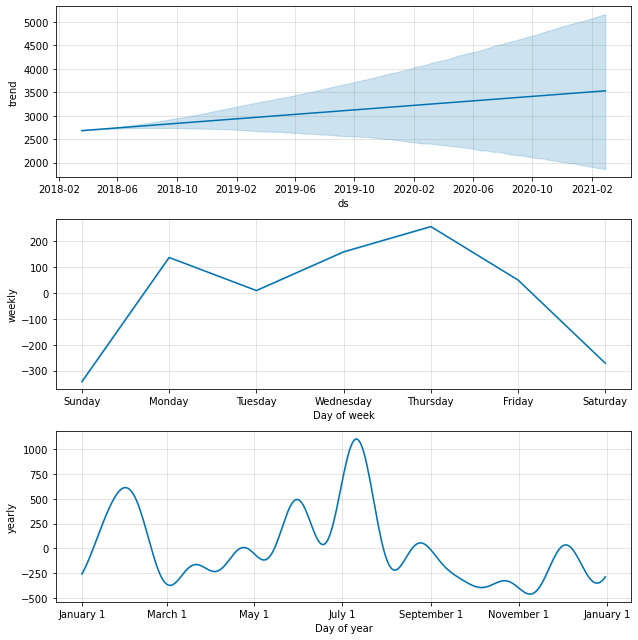

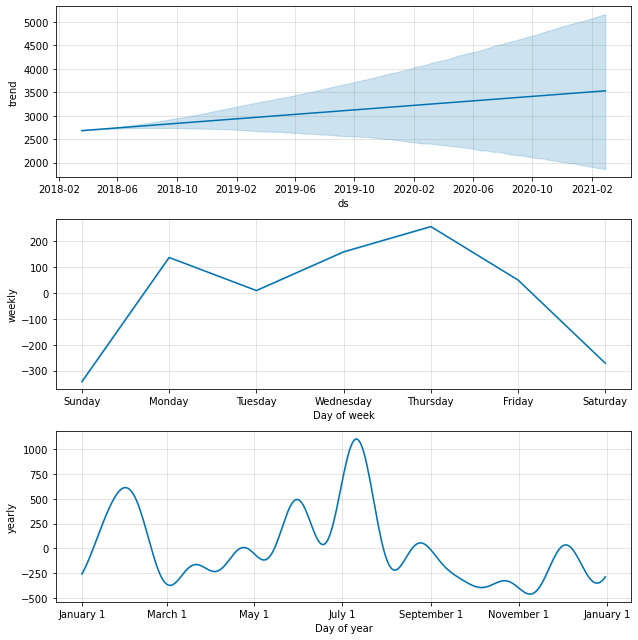

In [18]:
uni_model.plot_components(uni_forecast)

In [19]:
daily_mult_df = daily_df.copy()

In [20]:
daily_mult_df = daily_mult_df.rename(columns={'FullDate': 'ds','SysLoad': 'add1', 
                                              'Tmax': 'add2','GasPrice': 'add3','ElecPrice': 'y'})
daily_mult_df.head(3)

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.38,88.56,2751.700
1,2010-09-02,369.6,38898.99,88.56,570.810
2,2010-09-03,439.2,41665.76,106.80,504.975


In [21]:
daily_mult_train_df = daily_mult_df[:2757]
daily_mult_test_df = daily_mult_df[2757:]

daily_mult_train_df.shape, daily_mult_test_df.shape

((2757, 5), (1077, 5))

In [22]:
mult_model = Prophet()
mult_model.add_regressor('add1')
mult_model.add_regressor('add2')
mult_model.add_regressor('add3')
mult_model.fit(daily_mult_train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
mult_forecast = mult_model.predict(daily_mult_test_df)

In [24]:
mult_MAPE = MAPE(daily_mult_test_df['y'], mult_forecast['yhat'], 2)
print(f'MAPE of multivariate time series is {mult_MAPE}%.')

MAPE of multivariate time series is 233.42%.


In [25]:
# rmse

mult_RMSE = round(np.sqrt(mean_squared_error(daily_mult_test_df['y'], mult_forecast['yhat'])), 2)
print(f'RMSE of the multivariate time series is {mult_RMSE}.')

RMSE of the multivariate time series is 2709.23.


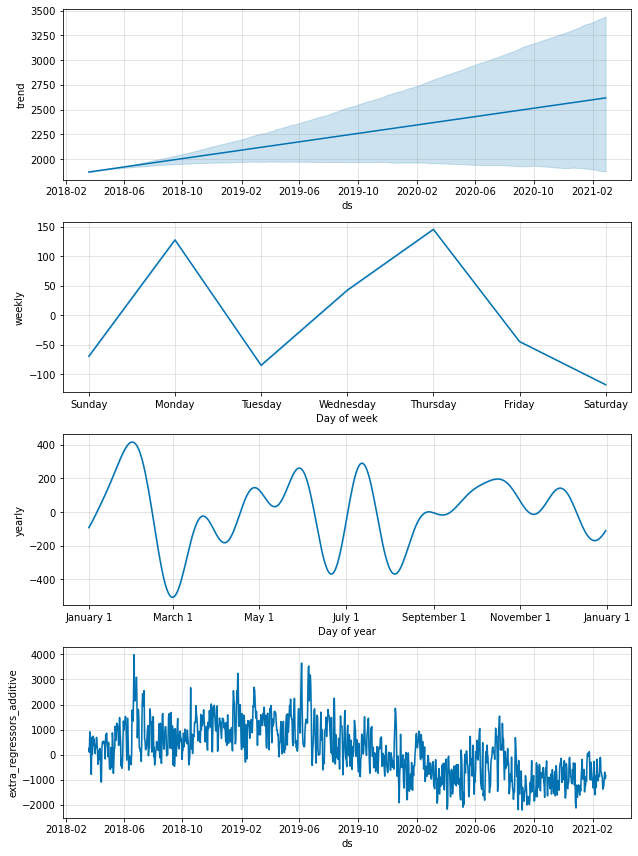

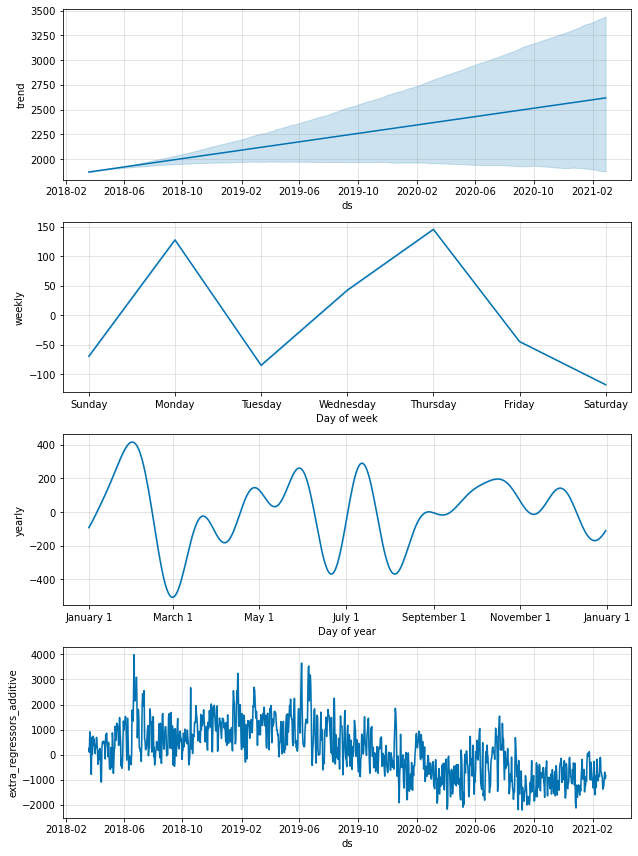

In [26]:
mult_model.plot_components(mult_forecast)

In [27]:
mult2_train_df = daily_mult_train_df.drop(columns=['add2'])
mult2_test_df = daily_mult_test_df.drop(columns=['add2'])

In [28]:
mult_model2 = Prophet()
mult_model2.add_regressor('add1')
mult_model2.add_regressor('add3')

In [29]:
mult_model2.fit(mult2_train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
mult_forecast_2 = mult_model2.predict(mult2_test_df)

In [31]:
mult_MAPE_2 = MAPE(mult2_test_df['y'], mult_forecast_2['yhat'], 2)
print(f'MAPE of the multivariate time series without Tmax is {mult_MAPE_2}%.')

MAPE of the multivariate time series without Tmax is 231.07%.
